Notebook to train a diffusion model on the 2D Muller Brown potential, and then compute transition paths with Onsager-Machlup (OM) optimization

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from mb_calculator import MullerBrownPotential
calculator = MullerBrownPotential(device = "cpu")

# Define various utility Functions

def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
    """
    Spherical linear interpolation between two vectors.
    Source: Andrej Karpathy's gist: https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355
    Args:
        v0 (torch.Tensor): the first vector
        v1 (torch.Tensor): the second vector
        t (torch.Tensor): scalar from 0 to 1 parameterizing the interpolation
    """
    v0 = v0.detach().cpu().numpy()
    v1 = v1.detach().cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1  # simple linear interpolation
    else:
        theta_0 = np.arccos(dot)  # angle between latent vectors
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1
    return v2

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)


def get_numpy(tensor):
    return tensor.to("cpu").detach().numpy()


# Plotting
def visualize_mb_data(dataset, normalize = False, title="Muller Brown Training Data"):
    mb_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4096, shuffle=True)

    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing = "xy")
    z = calculator.U_split(x, y).cpu()

    fig, ax = plt.subplots()
    colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
    ax.set(xlabel="x-axis", ylabel="y-axis", title=title)
    plt.colorbar(colorbar)

    # also plot batch from dataloader
    for i, batch in tqdm(enumerate(mb_dataloader)):
        x, force = batch
        if normalize:
            x = x * std.cpu() + mean.cpu()
        ax.scatter(x[:, 0], x[:, 1], color='red', s=0.1)
        
    ax.set_xlim([calculator.Lx, calculator.Hx])
    ax.set_ylim([calculator.Ly, calculator.Hy])

    plt.show()
    plt.close()


def plot_losses(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")

def plot_samples(samples: np.ndarray, title: str = "Muller Brown Samples") -> None:
    # plot a single plot with samples
    fig, ax = plt.subplots()
    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing = "xy")
    z = calculator.U_split(x, y).cpu()
    
        
    colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(colorbar)
    ax.scatter(samples[:, 0], samples[:, 1], s = 0.3, color='red')

    ax.set_xlim([calculator.Lx, calculator.Hx])
    ax.set_ylim([calculator.Ly, calculator.Hy])
    plt.title(title)
    plt.show()
    plt.close()

def save_multi_scatter_2d(data: np.ndarray, steps: np.ndarray, title: str, paths: np.ndarray = None) -> None:
    num = torch.sqrt(torch.tensor(data.shape[0])).int().item()
    fig, axs = plt.subplots(num, num, figsize=(16, 13))
    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing="xy")
    z = calculator.U_split(x, y).cpu()
    def plot(axis, i, j):
        colorbar = axis.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
        plt.colorbar(colorbar)
        
        # plot initial and final paths (before and after OM optimization)
        if paths is not None:
            axis.plot(paths[i * num + j, 0, :, 0], paths[i * num + j, 0, :, 1], color='orange', label='Initial Path')
            axis.plot(paths[i * num + j, -1, :, 0], paths[i * num + j, -1, :, 1], color='purple', label='Final Path')
            
        # plot samples
        axis.scatter(data[i * num + j, :, 0], data[i * num + j, :, 1], s = 1, color='red')

        # plot path endpoints with x
        axis.scatter(data[i * num + j, 0, 0], data[i * num + j, 0, 1], s = 100, color='orange', marker='x')
        axis.scatter(data[i * 3 + j, -1, 0], data[i * 3 + j, -1, 1], s = 100, color='orange', marker='x')

        axis.set_xlim([calculator.Lx, calculator.Hx])
        axis.set_ylim([calculator.Ly, calculator.Hy])
        axis.set_title(f"{steps[i * num + j]}")
        if paths is not None:
            axis.legend()

    if num == 1:
        plot(axs, 0, 0)
    else:
        for i in range(num):
            for j in range(num):
                plot(axs[i, j], i, j)
    fig.suptitle(title)


def linear_warmup_cosine_decay_lr_scheduler(optimizer, warmup_steps, total_steps, lr_min=0.0, lr_max=1.0):
    """
    Linear warmup with cosine decay 
    """
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            # Linear warmup
            warmup_factor = current_step / float(max(1, warmup_steps))
            return lr_min + warmup_factor * (lr_max - lr_min)
        else:
            # Cosine decay
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return lr_min + 0.5 * (lr_max - lr_min) * (1 + torch.cos(torch.tensor(torch.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

Loading simulations from directory: data/temp=700_timestep=5.0_friction=0.001/train_large


100%|██████████| 800/800 [05:43<00:00,  2.33it/s]


Loading simulations from directory: data/temp=700_timestep=5.0_friction=0.001/val_large


100%|██████████| 200/200 [01:26<00:00,  2.30it/s]
196it [00:25,  7.72it/s]


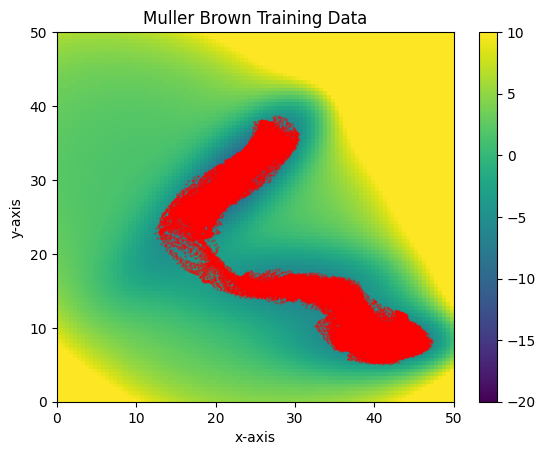

In [4]:
# Initialize training dataset
from mb_dataset import MBDataset

train_dataset = MBDataset(preload_sim_dir="data/temp=700_timestep=5.0_friction=0.001/train_large", load_forces = True, device = "cuda")
test_dataset = MBDataset(preload_sim_dir="data/temp=700_timestep=5.0_friction=0.001/val_large", load_forces = True, device = "cuda")
visualize_mb_data(train_dataset)


In [ ]:

from mb_actions import TruncatedAction, S2Action, HutchinsonAction
from simpleMB import SimpleMB
import random
from ase import units
import math
from contextlib import nullcontext
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np


class MLP(torch.nn.Module):
    """
    A simple MLP to parameterize the score function in the diffusion model.
    """

    def __init__(
        self, in_dim, hidden_dim, out_dim, device, conservative=False, act=F.gelu
    ):
        super(MLP, self).__init__()
        self.device = device
        self.in_dim = in_dim
        self.conservative = conservative
        self.mean = (
            torch.tensor(np.load("data/mb_mean.npy")).to(device).to(torch.float32)
        )
        self.std = torch.tensor(np.load("data/mb_std.npy")).to(device).to(torch.float32)

        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.act = act
        if conservative:
            self.fc5 = nn.Linear(hidden_dim, 1)
        else:
            self.fc5 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_, t):
        if len(x_.shape) == 1:  # if x_ is a single point, add batch dimension
            x_ = x_.unsqueeze(0)
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t).float().repeat(x_.shape[0], 1).to(self.device)
        with torch.enable_grad() if self.conservative else nullcontext():
            if self.conservative:
                x_.requires_grad = True

            x = torch.cat([x_, t], dim=1)

            x = self.act(self.fc1(x))
            x = self.act(self.fc2(x))
            x = self.act(self.fc3(x))
            x = self.act(self.fc4(x))
            x = self.fc5(x)
            if self.conservative:  # predicted noise is the gradient of a potential
                x = torch.autograd.grad(
                    x, x_, grad_outputs=torch.ones_like(x), create_graph=True
                )[0]
            return x


class MBDiffusionModel(torch.nn.Module):
    """
    A diffusion model for the Muller Brown potential using a simple MLP for the score function.
    """

    def __init__(self, mlp, num_steps, device):
        super(MBDiffusionModel, self).__init__()
        self.device = device
        self.num_steps = num_steps
        betas = self._cosine_variance_schedule(self.num_steps)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.mlp = mlp
        self.in_dim = mlp.in_dim
        self.mean = torch.tensor(np.load("data/mb_mean.npy")).to(device).to(torch.float32)
        self.std = torch.tensor(np.load("data/mb_std.npy")).to(device).to(torch.float32)
        
    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)

        return betas

    def forward(self, x, t):
        if isinstance(t, torch.Tensor):
            assert torch.logical_and(
                t < self.num_steps, t >= 0
            ).all(), "t must be between 0 and num_steps"
            assert torch.allclose(
                t, t.round()
            ), "Time must be an integer between 0 and num_steps"
        else:
            assert (
                t <= self.num_steps and t >= 0
            ), "Time must be between 0 and num_steps"
            assert round(t) == t, "Time must be an integer between 0 and num_steps"
        t = t / self.num_steps
        return self.mlp(x, t)

    def scaling_factor(self, t):
        scaling_factor = -units.kB * 700 / self.sqrt_one_minus_alphas_cumprod[t]
        return scaling_factor

    def force_func(self, x, t):
        noise_pred = self.forward(x, t)
        force = self.scaling_factor(t) * noise_pred
        force /= self.std  # empirically helps with convergence
        return force

    def laplacian_func(self, x, t):
        hessian_fn = torch.func.jacrev(self.force_func, argnums=0)
        hessian = hessian_fn(x, t)  # shape of [P x 2 x P x 2]
        indices = torch.arange(x.shape[0])
        laplace = torch.vmap(torch.diag)(hessian[indices, :, indices, :])
        return laplace

    def forward_diffusion(self, x, t, noise):
        # DDPM forward diffusion
        assert torch.all(torch.logical_and(x >= -5, x <= 5)), "x must be normalized"
        noised_x = (
            self.sqrt_alphas_cumprod[t] * x
            + self.sqrt_one_minus_alphas_cumprod[t] * noise
        )
        return noised_x

    def ddpm_update(self, x_t, t, temperature):
        """Standard DDPM update with no clipping."""
        pred = self.forward(x_t, t)

        alpha_t = self.alphas[t]
        alpha_t_cumprod = self.alphas_cumprod[t]
        beta_t = self.betas[t]
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t]
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_cumprod_t) * pred
        )

        if t > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod[t - 1]
            std = torch.sqrt(
                beta_t * (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod)
            )
        else:
            std = 0.0

        x_tm1 = mean + std * torch.randn_like(mean) * temperature
        return x_tm1

    def sample(self, num_samples, temperature=1.0):
        """Top level sampling function. Samples from the model starting from pure noise (t = T)."""
        x = torch.randn((num_samples, self.in_dim - 1)).to(self.device)
        return self.sample_from_t(x, self.num_steps - 1, temperature)

    def sample_from_t(self, x_t, latent_time, temperature=1.0):
        """Runs reverse diffusion on x_t starting from latent_time (between 0 and self.num_steps) and returns the final sample."""
        with torch.no_grad():
            # begin reverse diffusion process starting at t
            for t in range(latent_time, -1, -1):
                x_t = self.ddpm_update(x_t, t, temperature)
            return x_t

    def reconstruct(self, x, latent_time, temperature=1.0):
        """Forward diffusion of samples x to t = t and then sample from t to reconstruct x."""
        # Make sure x is normalized
        assert torch.all(torch.logical_and(x >= -5, x <= 5)), "x must be normalized"
        if isinstance(latent_time, torch.Tensor):
            latent_time = latent_time.item()
        if round(latent_time) != latent_time:
            latent_time = round(latent_time)

        with torch.no_grad():
            noised_x = self.forward_diffusion(
                x, latent_time, torch.randn_like(x).to(self.device)
            )
            return self.sample_from_t(noised_x, latent_time, temperature)

    def interpolation(
        self,
        x1,
        x2,
        path_length,
        latent_time,
        num_paths=10,
        interpolation_fn=torch.lerp,
        temperature=1.0,
    ):
        """ "
        Encode the two points into latent space, linearly or spherically interpolate, and decode.
        Note: Expects x1 and x2 to be normalized.
        """
        # Make sure x1 and x2 are normalized
        assert torch.all(torch.logical_and(x1 >= -5, x1 <= 5)), "x1 must be normalized"
        assert torch.all(torch.logical_and(x2 >= -5, x2 <= 5)), "x2 must be normalized"
        if isinstance(latent_time, torch.Tensor):
            latent_time = latent_time.item()

        if round(latent_time) != latent_time:
            latent_time = round(latent_time)

        x1 = x1.repeat(num_paths, 1)
        x2 = x2.repeat(num_paths, 1)
        original_x1 = x1.clone()
        original_x2 = x2.clone()

        with torch.no_grad():
            noise_1 = torch.randn_like(x1).to(self.device)
            noise_2 = torch.randn_like(x2).to(self.device)
            noised_x1 = self.forward_diffusion(x1, latent_time, noise_1)
            noised_x2 = self.forward_diffusion(x2, latent_time, noise_2)

        # linear interpolation of noised_x1 and noised_x2

        noised_xs = torch.stack(
            [
                interpolation_fn(noised_x1.cpu(), noised_x2.cpu(), alpha)
                for alpha in torch.linspace(0, 1, path_length)
            ]
        )
        noised_xs = noised_xs.permute((1, 0, 2)).to(self.device)

        # decode
        xs = self.sample_from_t(noised_xs.reshape(-1, 2), latent_time, temperature)

        xs = xs.reshape(num_paths, path_length, 2)
        xs = xs.clone().detach()

        # reset the endpoints
        xs[:, 0], xs[:, -1] = original_x1, original_x2

        return xs

    def om_interpolation(
        self,
        x1,
        x2,
        path_length,
        latent_time,
        encode_and_decode=True,
        initial_guess_time=0,
        num_paths=10,
        action_cls=TruncatedAction,
        initial_guess_fn=torch.lerp,
        om_steps=100,
        lr=2e-1,
        anneal=False,
        temperature=1.0,
        D=0.1,
        dt=0.01,
        gamma=0.01,
    ):
        """ "
        Encode the two points into latent space, perform OM optimization and then decode
        Note: Expects x1 and x2 to be normalized.
        """
        # Make sure x1 and x2 are normalized
        assert torch.all(torch.logical_and(x1 >= -5, x1 <= 5)), "x1 must be normalized"
        assert torch.all(torch.logical_and(x2 >= -5, x2 <= 5)), "x2 must be normalized"
        if isinstance(latent_time, torch.Tensor):
            latent_time = latent_time.item()
        if round(latent_time) != latent_time:
            latent_time = round(latent_time)

        if anneal:
            om_steps = self.num_steps  # to make sure we anneal from T to 0

        x1 = x1.repeat(num_paths, 1)
        x2 = x2.repeat(num_paths, 1)

        original_x1 = x1.clone()
        original_x2 = x2.clone()
        with torch.no_grad():
            noise_1 = torch.randn_like(x1).to(self.device)
            noise_2 = torch.randn_like(x2).to(self.device)
            if encode_and_decode:
                noised_x1 = self.forward_diffusion(x1, latent_time, noise_1)
                noised_x2 = self.forward_diffusion(x2, latent_time, noise_2)
            elif initial_guess_time != 0:
                noised_x1 = self.forward_diffusion(x1, initial_guess_time, noise_1)
                noised_x2 = self.forward_diffusion(x2, initial_guess_time, noise_2)
            else:
                noised_x1 = x1
                noised_x2 = x2

        # linear interpolation of noised_x1 and noised_x2
        noised_xs = torch.stack(
            [
                initial_guess_fn(noised_x1.cpu(), noised_x2.cpu(), alpha)
                for alpha in torch.linspace(0, 1, path_length)
            ]
        )

        if initial_guess_time != 0:
            # decode initial guess
            noised_xs = self.sample_from_t(
                noised_xs.reshape(-1, 2).to(self.device),
                initial_guess_time,
                temperature,
            )
            noised_xs = noised_xs.reshape(path_length, num_paths, 2)
            # reset the endpoints
            noised_xs[0], noised_xs[-1] = original_x1, original_x2

        noised_xs = noised_xs.permute((1, 0, 2)).to(
            self.device
        )  # shape of [num_paths x path_length x 2]
        optimizer = torch.optim.Adam([noised_xs], lr=lr)

        pbar = tqdm(range(om_steps))
        paths = []
        actions = []

        with torch.enable_grad():
            noised_xs.requires_grad = True
            # Optimization of path using OM action
            for i in pbar:
                if anneal:
                    diff_time = self.num_steps - i - 1  # anneal the time from T to 0
                else:
                    diff_time = latent_time

                force_func = lambda x: self.force_func(x, diff_time)
                laplace = lambda x: self.laplacian_func(x, diff_time)
                if action_cls == HutchinsonAction:
                    action_func = action_cls(
                        force_func=force_func,
                        laplace_func=laplace,
                        dt=dt,
                        gamma=gamma,
                        D=D,
                        diffusion_model=True,
                    )
                else:
                    action_func = action_cls(
                        force_func=force_func,
                        laplace_func=laplace,
                        dt=dt,
                        gamma=gamma,
                        D=D,
                    )

                action = torch.vmap(action_func, randomness="different")(
                    noised_xs
                ).mean()
                actions.append(action.item())

                pred_force = force_func(noised_xs.reshape(-1, 2))
                optimizer.zero_grad()
                (grads,) = torch.autograd.grad(action, noised_xs)

                with torch.no_grad():
                    # grads shape is [num_paths, path_length, 2]
                    # Set endpoint grads to 0
                    grads[:, 0], grads[:, -1] = torch.zeros(2).to(
                        self.device
                    ), torch.zeros(2).to(self.device)

                    noised_xs.grad = grads
                    optimizer.step()

                pbar.set_description(f"OM Action: {action.item()}")

                if i % int(max(1, om_steps / 10)) == 0:
                    with torch.no_grad():
                        decoded_path = self.sample_from_t(
                            noised_xs.reshape(-1, 2), latent_time, temperature
                        )
                        decoded_path = decoded_path.reshape(num_paths, path_length, 2)
                        paths.append(decoded_path.detach())

        # decode along optimized path
        with torch.no_grad():
            if encode_and_decode:
                xs = self.sample_from_t(
                    noised_xs.reshape(-1, 2), latent_time, temperature
                )
            else:
                xs = noised_xs
            xs = xs.reshape(num_paths, path_length, 2)
            xs = xs.clone().detach()

            # reset the endpoints
            xs[:, 0], xs[:, -1] = original_x1, original_x2

            return xs, paths, actions


In [18]:
import wandb
def train_mb_diffusion(train_dataset, test_dataset, model, n_epochs, device, lr, batch_size, force_supervision_level = None):
    """
    Trains the diffusion model on the Muller Brown potential dataset.
    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    """
    PI = torch.tensor([np.pi]).to(device)
    optimizer = optim.Adam(model.mlp.parameters(), lr = lr)
    scheduler = linear_warmup_cosine_decay_lr_scheduler(optimizer, warmup_steps = 100, \
                                                        total_steps = n_epochs * int(len(train_dataset) / batch_size), \
                                                        lr_min=0.0, lr_max=1.0)

    #normalize training data
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
    std = torch.tensor(train_dataset.std).to(device).to(torch.float32)

    train_losses = []
    test_losses = []
    for e in range(n_epochs):
        model.train()
        print(f"Epoch {e+1}")
        with torch.enable_grad():
            for x, force in tqdm(train_dataloader):
                optimizer.zero_grad()
                x = x.to(device)
                force = force.to(device)
                x = (x - mean) / std
                #sample diffusion timestep (uniform between 0 and num_steps exclusive)
                t = torch.randint(0, model.num_steps, (x.shape[0],1)).to(x.device)
                # sample noise and diffuse
                noise = torch.randn_like(x)
                noised_x = model.forward_diffusion(x, t, noise)
                #forward pass
                pred_noise = model(noised_x, t).to(torch.float32)
                #compute loss and optimize
                loss = F.mse_loss(pred_noise, noise)
                force_loss = 0
                if force_supervision_level is not None:
                    t = force_supervision_level* torch.ones_like(t)
                    pred_force = model.force_func(x, t)
                    pred_force = pred_force / torch.norm(pred_force, dim = 1).unsqueeze(-1)
                    force = force / torch.norm(force, dim = 1).unsqueeze(-1)
                    force_loss = F.mse_loss(pred_force, force)

                (loss+force_loss).backward()
                optimizer.step()
                scheduler.step()
                train_losses.append(loss.unsqueeze(-1))

                # for logging force loss
                with torch.no_grad():
                    t = torch.ones_like(t)
                    pred_force = model.force_func(x, t)
                    log_force_mse = F.mse_loss(pred_force, force)
                    log_force_cosine = F.cosine_similarity(pred_force, force).mean()
                if not DISABLE_WANDB_LOGGING:   
                    wandb.log({"train_loss": loss, "train_force_mse": log_force_mse, "train_force_cosine": log_force_cosine})

        model.eval()
        tls = []
        with torch.no_grad():
            for x, force in test_dataloader:
                
                x = x.to(device)
                force = force.to(device)
                x = (x - mean) / std
                
                #sample diffusion timestep (uniform between 0 and num_steps exclusive)
                t = torch.randint(0, model.num_steps, (x.shape[0],1)).to(x.device)

                # sample noise and diffuse
                noise = torch.randn_like(x)
                noised_x = model.forward_diffusion(x, t, noise)
                
                #forward pass
                pred_noise = model(noised_x, t).to(torch.float32)
                #compute loss and optimize
                loss = F.mse_loss(pred_noise, noise)
                tls.append(loss.unsqueeze(-1))

                # for logging force loss
                t = torch.ones_like(t)
                pred_force = model.force_func(x, t)
                log_force_mse = F.mse_loss(pred_force, force)
                log_force_cosine = F.cosine_similarity(pred_force, force).mean()

            test_loss = torch.cat(tls).sum(0) / len(tls)
            test_losses.append(test_loss.unsqueeze(-1))
            if not DISABLE_WANDB_LOGGING: 
                wandb.log({"test_loss": test_loss, "test_force_mse": log_force_mse, "test_force_cosine": log_force_cosine})
            # print("Test loss: ", test_losses[-1].item())
    
    return get_numpy(torch.cat(train_losses)), get_numpy(torch.cat(test_losses))


In [19]:

# Train model - can skip this if you want to just load the provided checkpoint

# Training config
config = {
    "n_epochs": 10,
    "batch_size": 4096,
    "num_steps": 256, # discretization steps in the diffusion process
    "lr": 1e-3,
    "force_supervision_level": None,
    "mlp_hidden_dim": 256,
    "conservative": False,
    "ac": F.gelu
}

# no wandb logging for now
DISABLE_WANDB_LOGGING = True

device = torch.device(torch.cuda.current_device())
mlp = MLP(3, config["mlp_hidden_dim"], 2, device, conservative=config["conservative"]).to(device).to(torch.float32)
model = MBDiffusionModel(mlp, num_steps = config["num_steps"], device = device).to(device).to(torch.float32)

if not DISABLE_WANDB_LOGGING:   
    os.environ["WANDB_MODE"] = "online"
    wandb.login()
    wandb.init(project="mb-diffusion-model", entity="ml-pdes", config=config, name="test")
    wandb.watch(mlp)

# Train model - this takes about 3 minutes on a single A6000 GPU
train_losses, test_losses = train_mb_diffusion(train_dataset, test_dataset, model, n_epochs = config["n_epochs"], \
                                                lr = config["lr"], batch_size = config["batch_size"], device = device, \
                                                force_supervision_level = config["force_supervision_level"])
plot_losses(train_losses, test_losses, title="Muller Brown Diffusion Model Losses")

# save model checkpoint (locally and on wandb)
os.makedirs("results/checkpoints", exist_ok=True)
torch.save(mlp.state_dict(), "results/checkpoints/mb_diffusion_model.pt")
if not DISABLE_WANDB_LOGGING:
    wandb.save('mb_diffusion_model.pt')
    wandb.finish()

/tmp/ipykernel_116706/1500137158.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/1500137158.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/1500137158.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/1500137158.py:75: UserWarning: To copy const

Epoch 1


  0%|          | 0/196 [00:00<?, ?it/s]

100%|██████████| 196/196 [00:13<00:00, 14.08it/s]


Epoch 2


100%|██████████| 196/196 [00:13<00:00, 14.03it/s]


Epoch 3


100%|██████████| 196/196 [00:13<00:00, 14.32it/s]


Epoch 4


100%|██████████| 196/196 [00:13<00:00, 14.01it/s]


Epoch 5


100%|██████████| 196/196 [00:14<00:00, 13.98it/s]


Epoch 6


100%|██████████| 196/196 [00:13<00:00, 14.01it/s]


Epoch 7


100%|██████████| 196/196 [00:14<00:00, 13.95it/s]


Epoch 8


100%|██████████| 196/196 [00:13<00:00, 14.14it/s]


Epoch 9


100%|██████████| 196/196 [00:14<00:00, 13.74it/s]


Epoch 10


100%|██████████| 196/196 [00:14<00:00, 13.95it/s]


/tmp/ipykernel_116706/1500137158.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/1500137158.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/3506146077.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

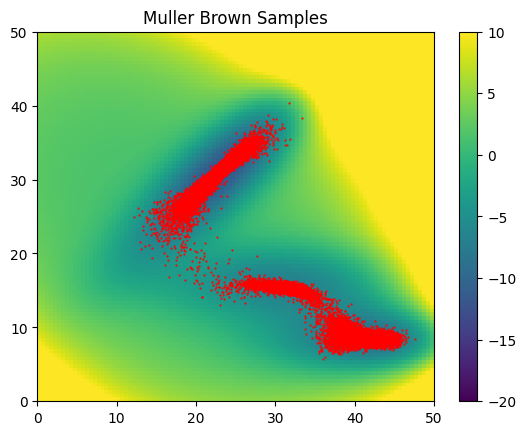

In [22]:
# Generate 100K i.i.d samples from the model
device = torch.device(torch.cuda.current_device())
mlp = MLP(3, 256, 2, device, conservative=False).to(device).to(torch.float32)
mlp.load_state_dict(torch.load("results/checkpoints/mb_diffusion_model.pt"))

model = MBDiffusionModel(mlp, num_steps = 256, device = device).to(device).to(torch.float32)
all_samples = model.sample(100000, temperature = 1)
mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
std = torch.tensor(train_dataset.std).to(device).to(torch.float32)

all_samples = all_samples*std + mean
all_samples = get_numpy(all_samples)
plot_samples(all_samples, title="Muller Brown Samples")
np.save("results/mb_diffusion_iid_samples.npy", all_samples)

In [23]:
# Define common args for interpolation experiments
latent_times = torch.linspace(0, 64, 9).to(torch.long).to(device)

# start and end points for interpolation - same as basins
x1 = torch.Tensor([[23, 30]]).to(device)
x2 = torch.Tensor([[40, 9]]).to(device)

# Normalize the points
x1 = (x1 - mean) / std
x2 = (x2 - mean) / std


/tmp/ipykernel_116706/3211138431.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/3211138431.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/2052274252.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

OM Action: 47.47289276123047: 100%|██████████| 1000/1000 [00:03<00:00, 250.91it/s]


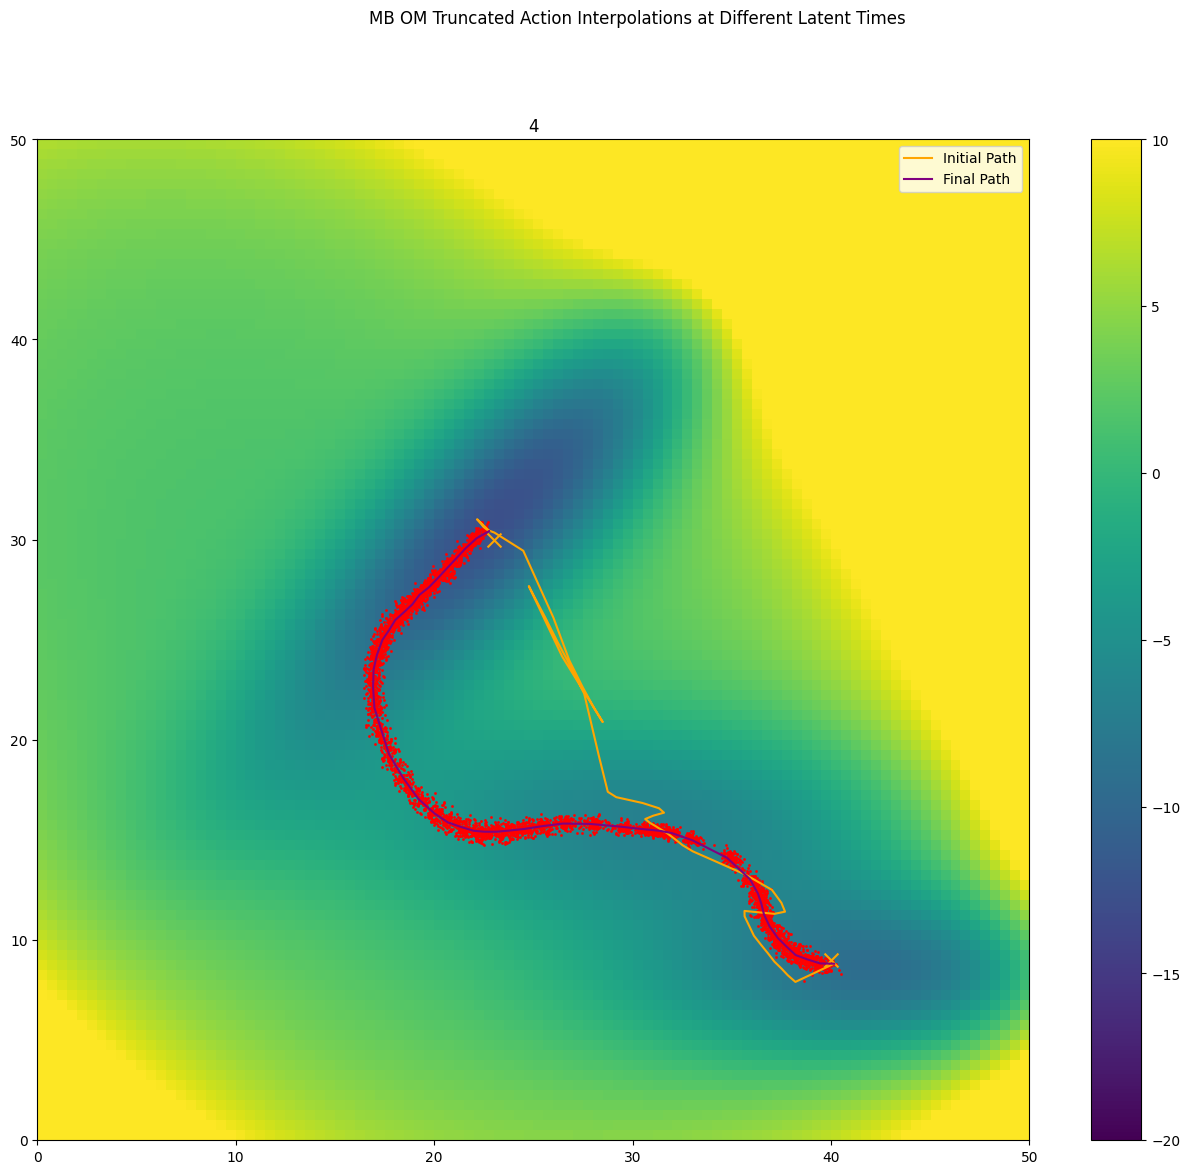

In [33]:
# om interpolation in diffusion space - TruncatedAction
latent_times = [4]
mlp = MLP(3, 256, 2, device, conservative=False).to(device).to(torch.float32)
mlp.load_state_dict(torch.load("results/checkpoints/mb_diffusion_model.pt"))
model = MBDiffusionModel(mlp, num_steps = 256, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, initial_guess_time = 0, encode_and_decode = True, action_cls = TruncatedAction, path_length=50, num_paths = 100, latent_time=time, om_steps = 1000, lr = 2e-1) for time in latent_times] 
samples, paths, actions = zip(*out)
samples = torch.stack(samples) # [len(latent_times) x num_paths x path_length x 2]
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths]) #[len(latent_times) x om_steps/save_every x num_paths x path_length x 2]
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

# Plot the samples and paths
save_multi_scatter_2d(samples, latent_times, title = "MB OM Truncated Action Interpolations at Different Latent Times", paths = paths)

In [ ]:
#Run unconstrained MD simulations using the optimized paths as initial conditions (this is optional, since we already provide the dataset)
# This dataset is used in committor/rate estimation)
# CAUTION: This will overwrite the existing dataset if it exists. Change the `save_path` if you want to keep the existing dataset.


from copy import deepcopy
ics = (deepcopy(samples) - mean.cpu().numpy()) / std.cpu().numpy()
ics = ics.squeeze()
diffusion_calculator = DiffusionModel_MullerBrownPotential(model = model, t = 0, device = model.device)
md_samples = MBDataset(save_path = 'data/diffusion_data_new_t=0_fewersims_long', calculator = diffusion_calculator, initial_positions = ics, timestep = 5.0, temperature = 700, n_steps = 10000, n_sims = 100, gamma = 0.001)
visualize_mb_data(md_samples, normalize=True, title="MD Samples from OM Interpolations")

/tmp/ipykernel_116706/270465078.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/270465078.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/3759962129.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

OM Action: -8954.205078125: 100%|██████████| 1000/1000 [00:06<00:00, 150.99it/s]  


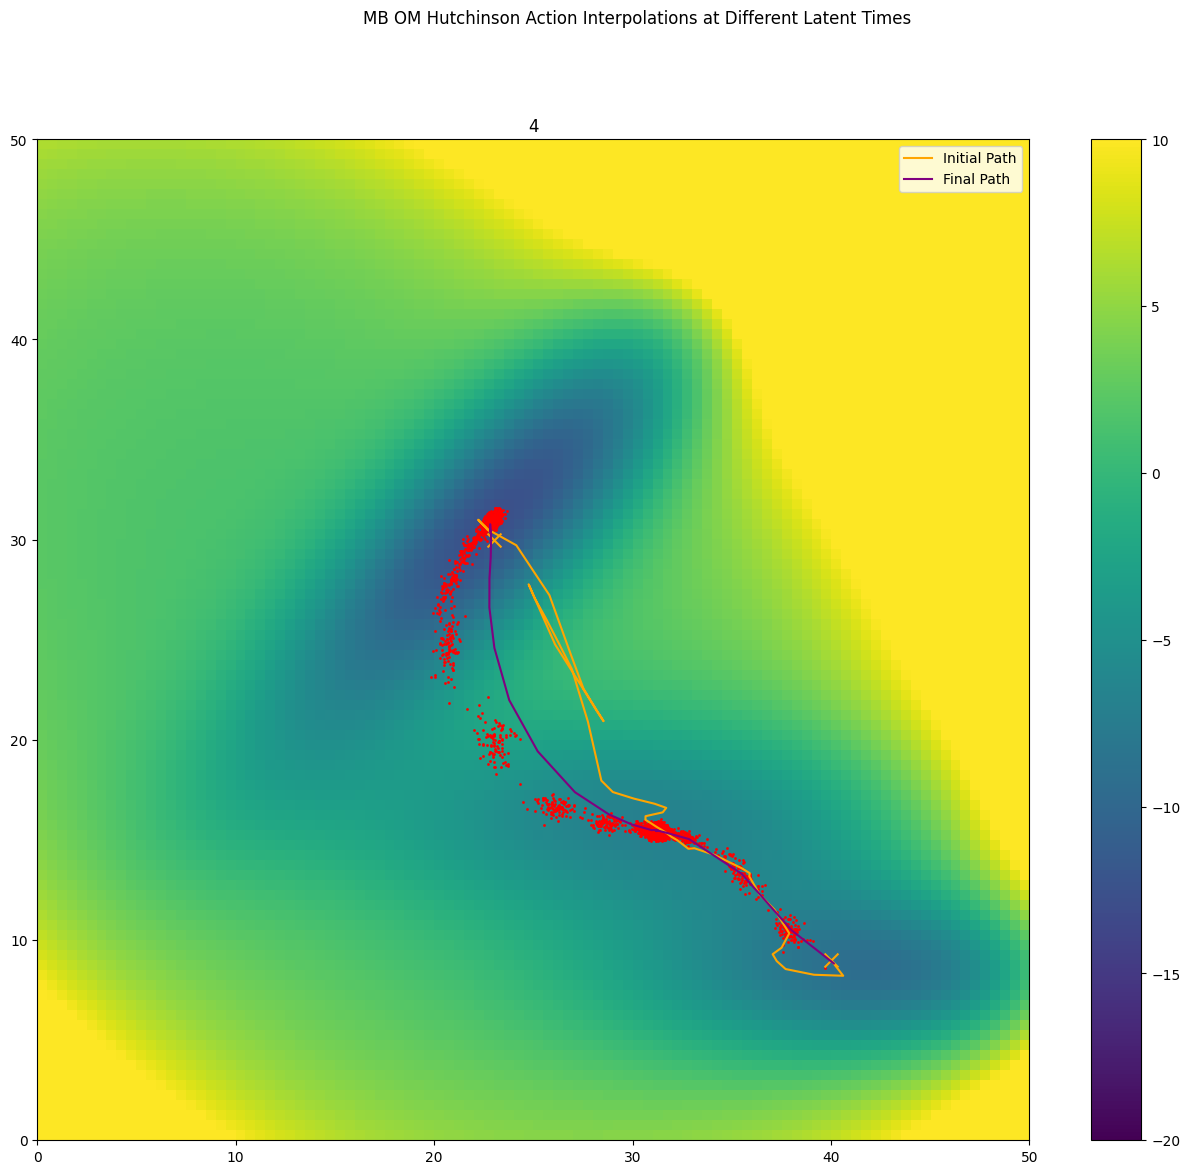

In [50]:
from mb_actions import HutchinsonAction
#  om interpolation in diffusion space - HutchinsonAction
mlp = MLP(3, 256, 2, device).to(device).to(torch.float32)
mlp.load_state_dict(torch.load("results/checkpoints/mb_diffusion_model.pt"))
latent_times = [4]
model = MBDiffusionModel(mlp, num_steps = 256, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, action_cls = HutchinsonAction, path_length=50, num_paths = 100, latent_time=time, om_steps = 1000, lr = 2e-1, D=1) for time in latent_times] 
samples, paths, actions = zip(*out)
samples = torch.stack(samples) # [len(latent_times) x num_paths x path_length x 2]
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths]) #[9 x om_steps/save_every x num_paths x path_length x 2]
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

save_multi_scatter_2d(samples, latent_times, title = "MB OM Hutchinson Action Interpolations at Different Latent Times", paths = paths)

/tmp/ipykernel_116706/270465078.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/270465078.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/1926259198.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

OM Action: 3648.57421875: 100%|██████████| 1000/1000 [00:10<00:00, 97.94it/s]    


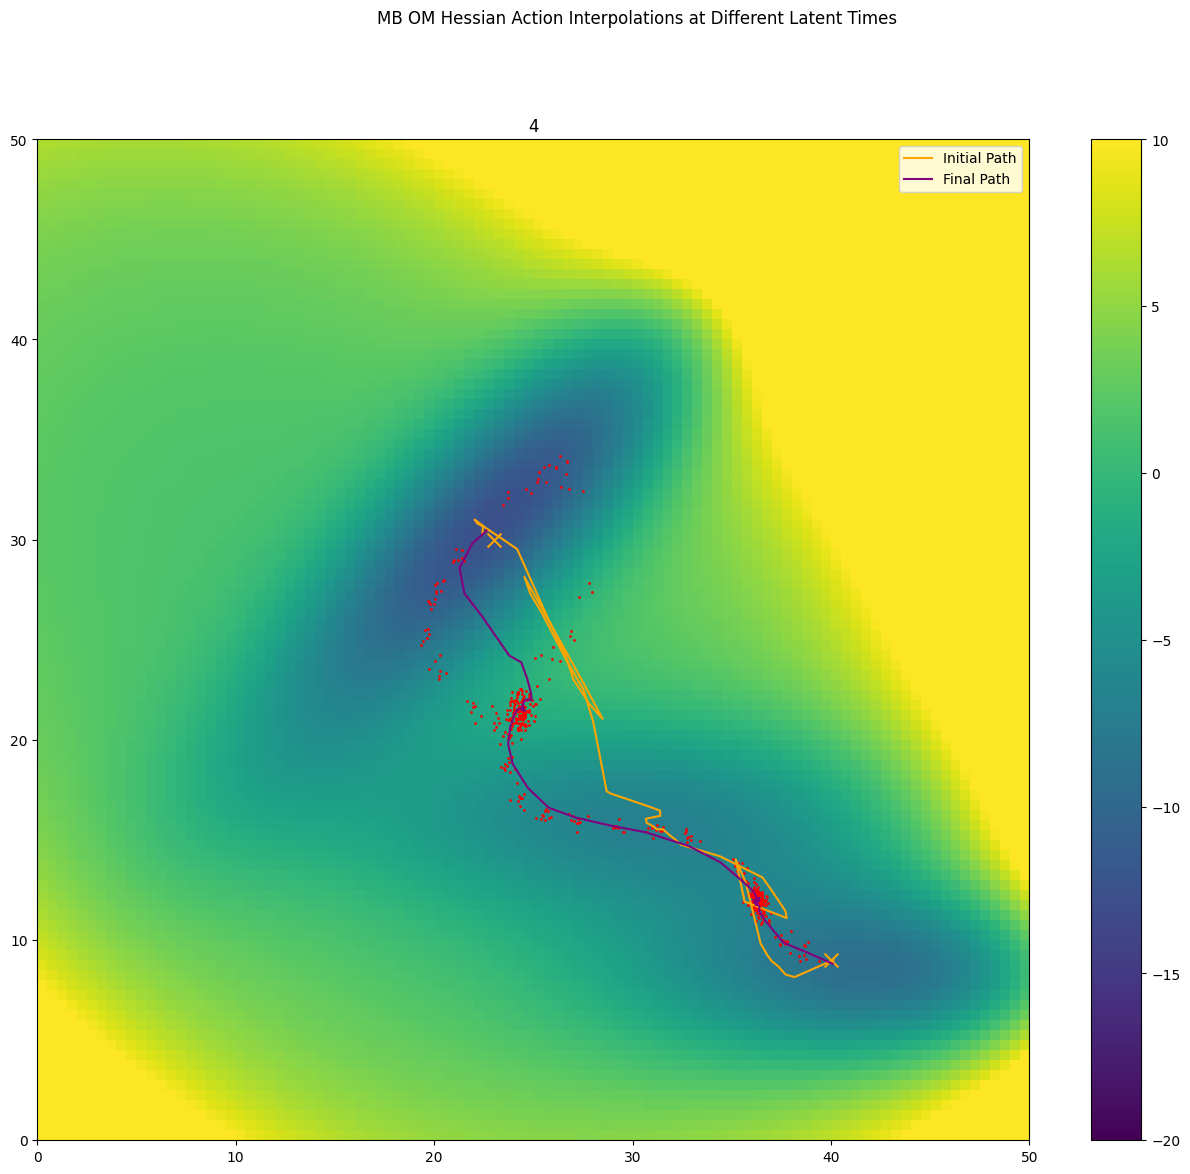

In [58]:
#  om interpolation in diffusion space - S2Action
latent_times = [4]
mlp = MLP(3, 256, 2, device).to(device).to(torch.float32)
mlp.load_state_dict(torch.load("results/checkpoints/mb_diffusion_model.pt"))
model = MBDiffusionModel(mlp, num_steps = 256, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, action_cls = S2Action, path_length=50, num_paths = 10, latent_time=time, om_steps = 1000, lr = 2e-1, D=1.0) for time in latent_times] 
samples, paths, actions = zip(*out)
samples = torch.stack(samples) # [len x num_paths x path_length x 2]
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths]) #[len(latent_times) x om_steps/save_every x num_paths x path_length x 2]
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

save_multi_scatter_2d(samples, latent_times, title = "MB OM Hessian Action Interpolations at Different Latent Times", paths = paths)

/tmp/ipykernel_116706/270465078.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_116706/270465078.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_116706/2924871656.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


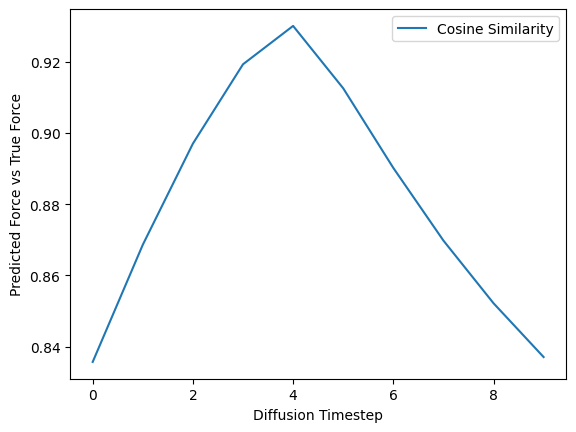

In [63]:
# Evaluate how well the diffusion model matches the true forces via cosine similarity.

# Loop over the training dataset
mlp = MLP(3, 256, 2, device).to(device).to(torch.float32)
mlp.load_state_dict(torch.load("results/checkpoints/mb_diffusion_model.pt"))
model = MBDiffusionModel(mlp, num_steps = 256, device = device).to(device).to(torch.float32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle = True)

all_cos_sims = []
all_forces = []
all_pred_forces = []
for t_ in tqdm(range(0, 10)):
    cos_sims = []
    for i, (x, force) in enumerate(test_dataloader):
        x = x.to(device)
        force = force.to(device)
        if t_ == 0:
            all_forces.append(force)
        x = (x - mean) / std
        t = t_ * torch.ones((x.shape[0], 1)).to(torch.long).to(device)
        pred_force = model.force_func(x, t)
        if t_ == 0:
            all_pred_forces.append(pred_force)
        cos_sim = F.cosine_similarity(pred_force, force, dim = 1)
        cos_sims.append(cos_sim.mean())
        
    all_cos_sims.append(torch.stack(cos_sims).mean().item())

plt.close()

plt.plot(all_cos_sims, label = "Cosine Similarity")
plt.ylabel("Predicted Force vs True Force")
plt.xlabel("Diffusion Timestep")
plt.legend()




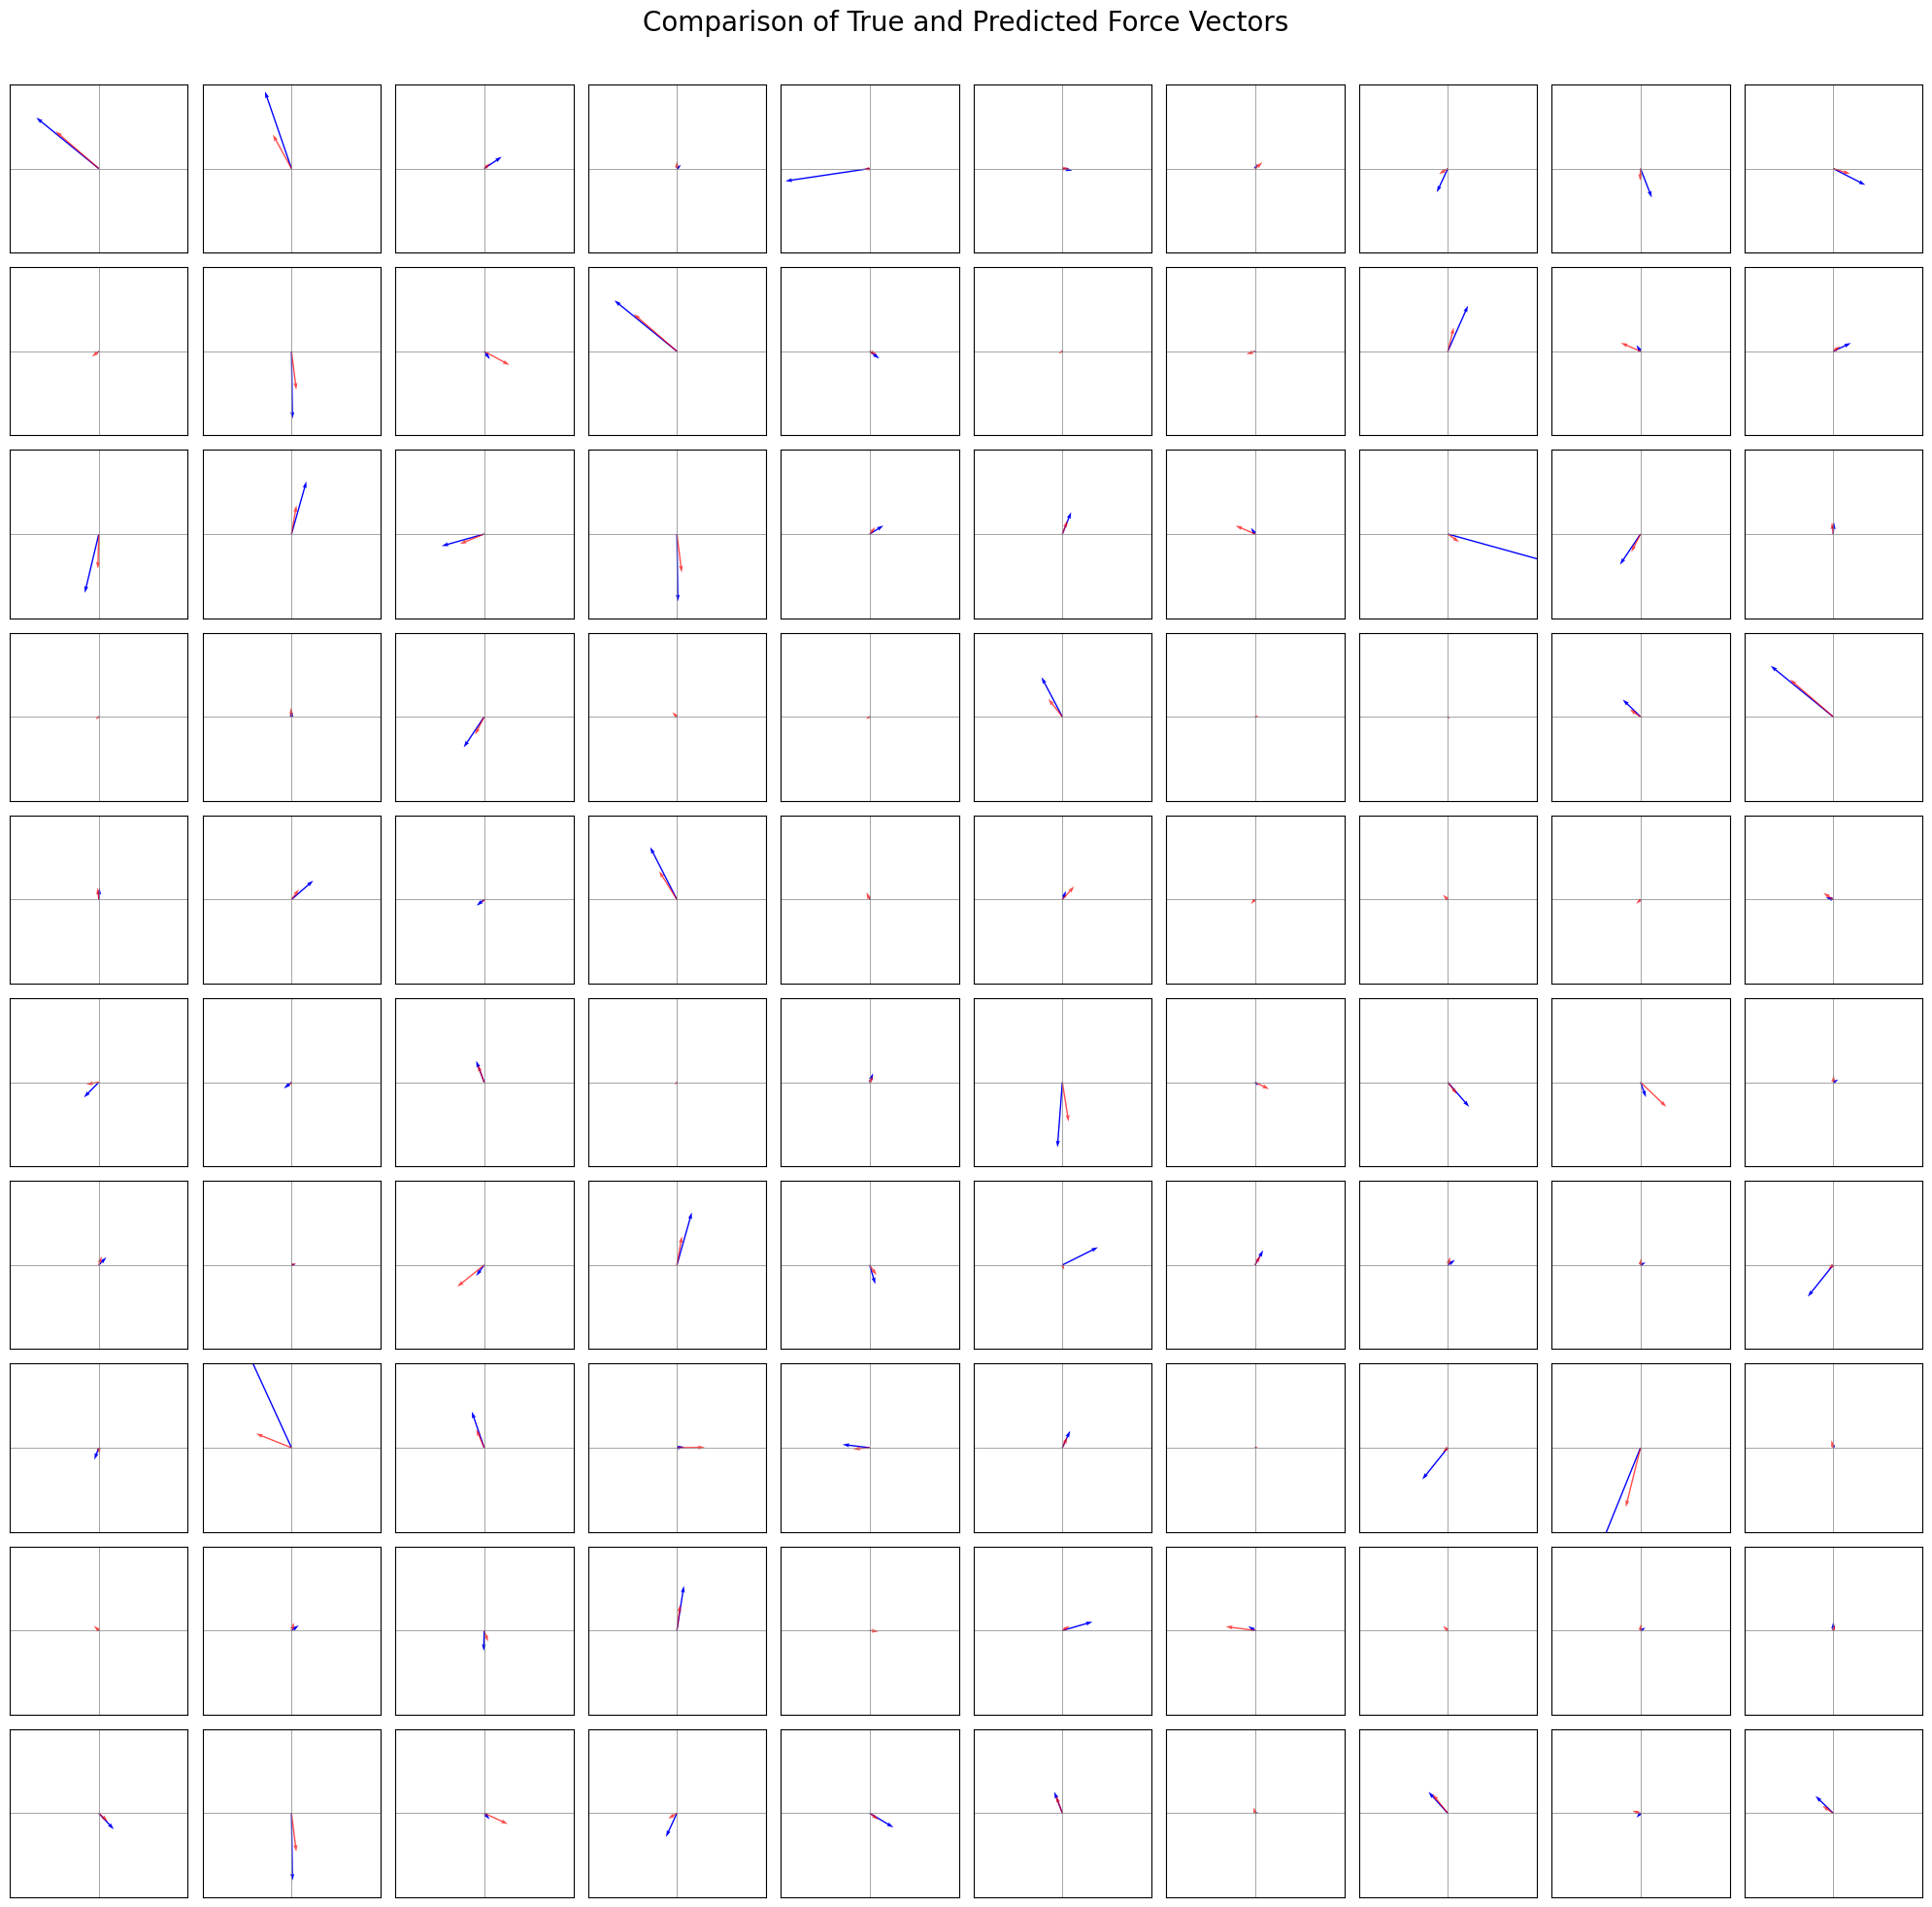

In [64]:
# sample some forces from all_forces and all_pred forces and plot them as arrows

# Generating the plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.suptitle('Comparison of True and Predicted Force Vectors', fontsize=20)
_all_forces = torch.cat(all_forces).detach().cpu()
_all_pred_forces = torch.cat(all_pred_forces).detach().cpu()
for i in range(10):
    for j in range(10):
        idx = torch.randint(0, len(all_forces), (1,)).item()
        
        
        ax = axes[i, j]
        ax.quiver(0, 0, _all_forces[idx, 0], _all_forces[idx, 1], angles='xy', scale_units='xy', scale=1, color='blue')
        ax.quiver(0, 0, _all_pred_forces[idx, 0], _all_pred_forces[idx, 1], angles='xy', scale_units='xy', scale=1, color='red', alpha=0.7)
        
        ax.axhline(0, color='grey', lw=0.5)
        ax.axvline(0, color='grey', lw=0.5)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.grid(True, which='both', linestyle='--', lw=0.5)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

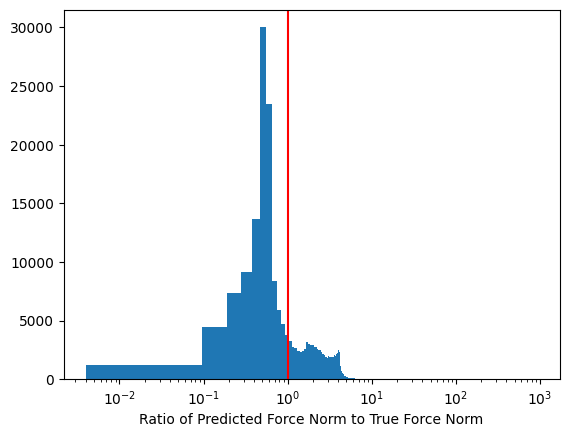

In [65]:
# plot histogram of ratios between predicted and true forces
ratios = torch.norm(_all_pred_forces, dim = 1) / torch.norm(_all_forces, dim = 1)
plt.figure()
plt.hist(get_numpy(ratios), bins = 10000)
plt.xscale("log")
plt.xlabel("Ratio of Predicted Force Norm to True Force Norm")
plt.axvline(1, color = "red")